In [1]:
import qiskit
import numpy as np
from shadow_clifford import ClassicalShadow
from qiskit.quantum_info import Pauli, SparsePauliOp
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import pandas as pd

def eigensolver(s, hoff, hdiag):
    S = np.array([[1, s.real],[s.real,1]])
    H = np.array([[hdiag.real, hoff.real],[hoff.real, hdiag.real]])
    eigvals = eigh(H, S, eigvals_only=True, subset_by_index=[0, 1])
    return eigvals

def dep(p, rho):
    rho = np.array(rho)
    n = int(np.log2(np.shape(rho)[0]))
    return qiskit.quantum_info.DensityMatrix((1-p)*rho + p*np.eye(2**n)/2**n)

ref1 = [-4.04428374e-17+6.84026750e-17j,  1.57689901e-16-2.09549877e-16j,
       -2.54203437e-16+2.37034147e-16j,  9.89665456e-01+1.11022302e-15j,
        8.53310932e-17+4.89498545e-17j, -5.10409563e-17-7.50020036e-18j,
        1.05562794e-15-4.66843267e-16j, -1.09781758e-17-2.94116390e-17j,
       -1.24394555e-17-4.33982534e-17j, -4.90248239e-16-1.92205010e-17j,
       -6.78313947e-17-1.24724479e-16j,  9.25211277e-17-9.85027359e-17j,
       -1.43395555e-01-2.21031896e-16j,  1.38634603e-16-9.15119396e-17j,
       -1.00178491e-16-7.90560994e-17j,  2.81287772e-17-7.04662818e-17j]
rho1 = qiskit.quantum_info.DensityMatrix(ref1)

ref2 = [ 2.78547601e-18-2.49498567e-17j, -1.58742474e-16-3.55330186e-16j,
        2.16609908e-16-2.82403633e-16j, -6.10622664e-16-8.65265655e-01j,
        6.31302052e-17+1.60032916e-16j,  7.35833269e-17+1.93167449e-16j,
       -2.77555756e-16-2.99667310e-01j, -4.14374502e-16+1.62537109e-19j,
        7.98240847e-17-6.73495382e-17j, -1.11022302e-16-2.99667310e-01j,
       -1.71427315e-17+9.14602200e-17j,  1.10302771e-16-4.22197611e-16j,
       -1.11022302e-16+2.67795357e-01j,  1.21205829e-16+9.25910513e-17j,
       -2.96046751e-17-1.50472834e-16j, -1.33450810e-16+5.78675791e-18j]
rho2 = qiskit.quantum_info.DensityMatrix(ref2)

# Define the terms in the Hamiltonian
terms = [
    (-0.4196023680844313, 'IIII'),
    (-0.0444822913474488, 'XXYY'),
    (0.0444822913474488, 'XYYX'),
    (0.03837663252892021, 'XZXI'),
    (-0.01989799759163713, 'XZXZ'),
    (0.018478634752613642, 'XIXI'),
    (0.0444822913474488, 'YXXY'),
    (-0.0444822913474488, 'YYXX'),
    (0.03837663252892021, 'YZYI'),
    (-0.01989799759163713, 'YZYZ'),
    (0.018478634752613642, 'YIYI'),
    (0.10933758934583135, 'ZIII'),
    (-0.018478634752613635, 'ZXZX'),
    (-0.018478634752613635, 'ZYZY'),
    (0.14058793568268865, 'ZZII'),
    (0.09604367392140638, 'ZIZI'),
    (0.15645711712241647, 'ZIIZ'),
    (-0.03837663252892032, 'IXZX'),
    (0.019897997591637115, 'IXIX'),
    (-0.03837663252892032, 'IYZY'),
    (0.019897997591637115, 'IYIY'),
    (0.10933758934583139, 'IZII'),
    (0.15645711712241644, 'IZZI'),
    (0.09604367392140638, 'IZIZ'),
    (-0.07555373828970036, 'IIZI'),
    (0.14742615730183484, 'IIZZ'),
    (-0.07555373828970031, 'IIIZ')
]

simplified_terms = [(-0.6365898561329018, "IIII"), (-0.17792916538979606, "XXYY"), (0.153506530287386, "XZXI"), (0.1535065227735808, "XIXI"),(0.36978266455828424, "ZIII")]

reversed_terms = [(coeff, label[::-1]) for coeff, label in terms]
hamiltonian = sum(coeff * SparsePauliOp(Pauli(label)) for coeff, label in reversed_terms)
hamiltonian_matrix = hamiltonian.to_matrix()

simplified_hamiltonian = sum(coeff * SparsePauliOp(Pauli(label[::-1])) for coeff, label in simplified_terms)
simplified_hamiltonian_matrix = simplified_hamiltonian.to_matrix()

s_off_true = np.sqrt(np.trace(rho1.to_operator() @ rho2.to_operator()))
h_diag_true = np.trace(rho1.to_operator() @ hamiltonian_matrix)
h_s_true = np.trace(rho1.to_operator() @ rho2.to_operator() @ hamiltonian_matrix)
h_off_true = h_s_true/s_off_true
s0_true, t1_true = eigensolver(s_off_true, h_off_true, h_diag_true)

def print_metrics(s_off, h_off, h_diag, s0_list, t1_list, em = False):
    mean_s_off = np.mean(s_off)
    std_s_off = np.std(s_off)
    error_s_off = np.mean([abs(x - s_off_true) for x in s_off])

    mean_h_off = np.mean(h_off)
    std_h_off = np.std(h_off)
    error_h_off = np.mean([abs(x - h_off_true) for x in h_off])

    mean_h_diag = np.mean(h_diag)
    std_h_diag = np.std(h_diag)
    error_h_diag = np.mean([abs(x - h_diag_true) for x in h_diag])

    mean_s0 = np.mean(s0_list)
    std_s0 = np.std(s0_list)
    error_s0 = np.mean([abs(x - s0_true) for x in s0_list])

    mean_t1 = np.mean(t1_list)
    std_t1 = np.std(t1_list)
    error_t1 = np.mean([abs(x - t1_true) for x in t1_list])

    if em == None:
        print("Metrics     | S_off    | H_off    | H_diag  | S0      | T1")
        print("------------|----------|----------|---------|---------|----")
        print("True        | 0.895    | -0.954   | -1.042  | -1.0535 | -0.828")
        print(f"Mean        | {mean_s_off:.4f}   | {mean_h_off.real:.4f}  | {mean_h_diag.real:.4f} | {mean_s0:.4f} | {mean_t1:.4f}")
        print(f"STD         | {std_s_off:.4f}   | {std_h_off:.4f}   | {std_h_diag.real:.4f}  | {std_s0:.4f}  | {std_t1:.4f}")
        print(f"Error       | {error_s_off:.4f}   | {error_h_off:.4f}   | {error_h_diag:.4f}  | {error_s0:.4f}  | {error_t1:.4f}")
    else:
        em_s_off, em_h_off, em_h_diag, em_s0, em_t1 = em
        em_mean_s_off = np.mean(em_s_off)
        em_std_s_off = np.std(em_s_off)
        em_error_s_off = np.mean([abs(x - s_off_true) for x in em_s_off])
        em_mean_h_off = np.mean(em_h_off)
        em_std_h_off = np.std(em_h_off)
        em_error_h_off = np.mean([abs(x - h_off_true) for x in em_h_off])
        em_mean_h_diag = np.mean(em_h_diag)
        em_std_h_diag = np.std(em_h_diag)
        em_error_h_diag = np.mean([abs(x - h_diag_true) for x in em_h_diag])
        em_mean_s0 = np.mean(em_s0)
        em_std_s0 = np.std(em_s0)
        em_error_s0 = np.mean([abs(x - s0_true) for x in em_s0])
        em_mean_t1 = np.mean(em_t1)
        em_std_t1 = np.std(em_t1)
        em_error_t1 = np.mean([abs(x - t1_true) for x in em_t1])

        print("Metrics     | S_off    | H_off    | H_diag  | S0      | T1")
        print("------------|----------|----------|---------|---------|----")
        print("True        | 0.895    | -0.954   | -1.042  | -1.0535 | -0.828")
        print(f"Mean        | {mean_s_off:.4f}   | {mean_h_off.real:.4f}  | {mean_h_diag.real:.4f} | {mean_s0:.4f} | {mean_t1:.4f}")
        print(f"STD         | {std_s_off:.4f}   | {std_h_off:.4f}   | {std_h_diag.real:.4f}  | {std_s0:.4f}  | {std_t1:.4f}")
        print(f"Error       | {error_s_off:.4f}   | {error_h_off:.4f}   | {error_h_diag:.4f}  | {error_s0:.4f}  | {error_t1:.4f}")
        print("------------|----------|----------|---------|---------|----")
        print("EM          | S_off    | H_off    | H_diag  | S0      | T1")
        print("------------|----------|----------|---------|---------|----")
        print(f"Mean        | {em_mean_s_off.real:.4f}   | {em_mean_h_off.real:.4f}  | {em_mean_h_diag.real:.4f} | {em_mean_s0:.4f} | {em_mean_t1:.4f}")
        print(f"STD         | {em_std_s_off:.4f}   | {em_std_h_off:.4f}   | {em_std_h_diag.real:.4f}  | {em_std_s0:.4f}  | {em_std_t1:.4f}")
        print(f"Error       | {em_error_s_off:.4f}   | {em_error_h_off:.4f}   | {em_error_h_diag:.4f}  | {em_error_s0:.4f}  | {em_error_t1:.4f}")

print(f"s0_shadow = {s0_true}")
print(f"t1_shadow = {t1_true}")
print(f"s_off_shadow = {s_off_true}")
print(f"h_off_shadow = {h_off_true}")
print(f"h_diag_shadow = {h_diag_true}")

s0_shadow = -1.0535137399660863
t1_shadow = -0.8284433437356912
s_off_shadow = (0.8947241928601519-3.7884710497051973e-32j)
h_off_shadow = (-0.9544514644714568-6.7504896955333126e-18j)
h_diag_shadow = (-1.0416665061528663+2.7733391199176196e-32j)


In [2]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.compiler import transpile
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, phase_damping_error,  thermal_relaxation_error

# T1 = 50e-6  # 50 microseconds
# T2 = 70e-6  # 70 microseconds, must be T2 >= T1/2 for physical validity
# gate_time = 50e-9  # 50 nanoseconds
# thermal_error = thermal_relaxation_error(T1, T2, gate_time)

# noise_model.add_all_qubit_quantum_error(thermal_error, ['u1', 'u2', 'u3'])
# noise_model.add_all_qubit_quantum_error(thermal_error.expand(thermal_error), ['cx'])

ansatz1 =  QuantumCircuit().from_qasm_str(open('ansatzes0_simplified.qasm', 'r').read())
ref1_circ = QuantumCircuit(4,4)
ref1_circ.x(0)
ref1_circ.x(1)
ref1_circ = ref1_circ.compose(ansatz1)
ref1_circ = transpile(ref1_circ, basis_gates=['u3', 'cx'], optimization_level=3)
ref1_circ.save_density_matrix()
ref1_result= execute(ref1_circ, backend =  AerSimulator(method = "density_matrix")).result()
dm1 = ref1_result.data()['density_matrix']

ansatz2 =  QuantumCircuit().from_qasm_str(open('ansatzes1_simplified.qasm', 'r').read())
ref2_circ = QuantumCircuit(4,4)
ref2_circ.x(0)
ref2_circ.x(1)
ref2_circ = ref2_circ.compose(ansatz2)
ref2_circ = transpile(ref2_circ, basis_gates=['u3', 'cx'], optimization_level=3)
ref2_circ.save_density_matrix()
ref2_result= execute(ref2_circ, backend =  AerSimulator(method = "density_matrix")).result()
dm2 = ref2_result.data()['density_matrix']
ref1_circ.count_ops()

OrderedDict([('u3', 113), ('cx', 63), ('save_density_matrix', 1)])

# change number of shots

In [ ]:
# 2 h to run 10 samples for shots up to 1e6
total_shots = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
# note the allocation of number of repeats and shots
param_list = [(int(np.sqrt(x)), int(np.sqrt(x))) for x in total_shots]
s_off_list = [] 
h_off_list = []
h_diag_list = []
s0_list = []
t1_list = []
fidelity1_list = []
fidelity2_list = []
rho1 = qiskit.quantum_info.DensityMatrix(dm1)
rho2 = qiskit.quantum_info.DensityMatrix(dm2)
for (num_repeats, num_shots) in param_list:
    s_off = []
    h_off = []
    h_diag = []
    cs1_list = []
    cs2_list = []
    s0 = []
    t1 = []
    fidelity1 = []
    fidelity2 = []

    i = 0
    # 6h for 10 samples, 
    while i < 10:
        cs1 = ClassicalShadow(rho1)
        cs1.collect(repeats=num_repeats, shots=num_shots)
        dm1 = np.array(cs1.recover_density())
        #dm1_list.append(dm1)

        cs2 = ClassicalShadow(rho2)
        cs2.collect(repeats=num_repeats, shots=num_shots)
        dm2 = np.array(cs2.recover_density())
        #dm2_list.append(dm2)

        # s_off_tmp = np.sqrt(np.trace(dm1 @ dm2).real)
        # h_diag_tmp1 = cs1.estimate(hamiltonian_matrix).real
        # h_diag_tmp2 = cs2.estimate(hamiltonian_matrix).real
        # # take minimum of the two estimates for h_diag
        # h_diag_tmp = min(h_diag_tmp1, h_diag_tmp2)
        # h_off_tmp = np.trace(dm1 @ dm2 @ hamiltonian_matrix)/s_off_tmp

        # em_factor = np.trace(dm1 @ dm1) * np.trace(dm2 @ dm2)
        # em_s_off_tmp = np.sqrt(np.trace(dm1 @ dm1 @ dm2 @ dm2)/em_factor)
        # em_h_diag_tmp = np.trace(dm1 @ dm1 @ hamiltonian_matrix)/np.trace(dm1 @ dm1)
        # em_h_off_tmp = np.trace(dm1 @ dm1 @ dm2 @ dm2 @ hamiltonian_matrix)/em_factor/em_s_off_tmp

        # distilled to the 3rd order!!!!!!!!!!!!!!!!!
        em_factor = np.trace(dm1 @ dm1 @ dm1) * np.trace(dm2 @ dm2 @ dm2)
        s_off_tmp = np.sqrt(np.trace(dm1 @ dm1 @ dm1 @ dm2 @ dm2 @ dm2).real/em_factor)
        em_h_diag_tmp1 = np.trace(dm1 @ dm1 @ dm1 @ hamiltonian_matrix)/np.trace(dm1 @ dm1 @ dm1)
        em_h_diag_tmp2 = np.trace(dm2 @ dm2 @ dm2 @ hamiltonian_matrix)/np.trace(dm2 @ dm2 @ dm2)
        h_diag_tmp = (em_h_diag_tmp1 + em_h_diag_tmp2)/2
        h_off_tmp = np.trace(dm1 @ dm1 @ dm1 @ dm2 @ dm2 @ dm2 @ hamiltonian_matrix)/em_factor/s_off_tmp

        try:
            eigvals = eigensolver(s_off_tmp, h_off_tmp, h_diag_tmp)
            #cs1_list.append(cs1)
            #cs2_list.append(cs2)
            s_off.append(s_off_tmp.real)
            h_diag.append(h_diag_tmp.real)
            h_off.append(h_off_tmp.real)
            s0.append(eigvals[0])
            t1.append(eigvals[1])
            fidelity1.append(np.trace(rho1 @ dm1).real)
            fidelity2.append(np.trace(rho2 @ dm2).real)

            print(i)
            i += 1
        except:
            print("failed")
    print('done')
    s_off_list.append(s_off)
    h_off_list.append(h_off)
    h_diag_list.append(h_diag)
    s0_list.append(s0)
    t1_list.append(t1)
    fidelity1_list.append(fidelity1)
    fidelity2_list.append(fidelity2)

0
1
2
3
4
5
6
7
8
9
done
0
1
2
3
4
5
6
7
8
9
done
0
1
2
3
4
5
6
7
8
9
done
0
1
2
3
4
5
6
7
8
9
done
0
1
2
3
4
5
6
7
8
9
done
0
1
2
3
4
5
6
7
8
9
done


In [5]:
# calculate variance of s0 for each shot
s0_var = [np.var(x) for x in s0_list]

In [6]:
s0_var

[0.011244066976360444,
 0.0008518647051612698,
 1.796625216969076e-05,
 2.1192361109961945e-06,
 5.02149230921054e-07,
 1.6749912100400506e-07]

In [3]:
# data should be nested list
data = {
    "s_off": s_off_list,
    "h_off": h_off_list,
    "h_diag": h_diag_list,
    "s0": s0_list,
    "t1": t1_list,
    "fidelity1": fidelity1_list,
    "fidelity2": fidelity2_list
}
df = pd.DataFrame(data)
df.to_csv("data/shadow_noiseless.csv")

NameError: name 's_off_list' is not defined

In [12]:
df = pd.read_csv("data3/shadow_noiseless.csv")

In [4]:
import pandas as pd

# Read the CSV file directly
df = pd.read_csv("data3/shadow_noiseless.csv")

# Select the columns to process
columns_to_process = ['s_off', 'h_off', 'h_diag', 's0', 't1', 'fidelity1', 'fidelity2']

# Convert selected columns into lists
s_off_list = df['s_off'].tolist()
h_off_list = df['h_off'].tolist()
h_diag_list = df['h_diag'].tolist()
s0_list = df['s0'].tolist()
t1_list = df['t1'].tolist()
fidelity1_list = df['fidelity1'].tolist()
fidelity2_list = df['fidelity2'].tolist()


In [5]:
h_diag_list

[-1.0363877258519447,
 -1.0492451489194192,
 -0.9916157558508518,
 -0.9708607861933986,
 -1.0224122013785046,
 -1.0607370551718125,
 -1.0326251801566233,
 -1.0206110868519338,
 -1.0615546851221926,
 -1.0480931165070932]

In [3]:
import ast
df = pd.read_csv("data3/shadow_noiseless.csv")
columns_to_process = ['s_off', 'h_off', 'h_diag', 's0', 't1', 'fidelity1', 'fidelity2']
s_off_list = df['s_off'].apply(ast.literal_eval).tolist()
h_off_list = df['h_off'].apply(ast.literal_eval).tolist()
h_diag_list = df['h_diag'].apply(ast.literal_eval).tolist()
s0_list = df['s0'].apply(ast.literal_eval).tolist()
t1_list = df['t1'].apply(ast.literal_eval).tolist()
fidelity1_list = df['fidelity1'].apply(ast.literal_eval).tolist()
fidelity2_list = df['fidelity2'].apply(ast.literal_eval).tolist()

ValueError: malformed node or string: 0.9020006790469424

In [12]:
print("s_off_list = ", s_off_list)
print("h_off_list = ", h_off_list)
print("h_diag_list = ", h_diag_list)
print("s0_list = ", s0_list)
print("t1_list = ", t1_list)
print("fidelity1_list = ", fidelity1_list)
print("fidelity2_list = ", fidelity2_list)

s_off_list =  [[0.3866276159848395, 0.39850746871868276, 0.37697295480452453, 0.26411027020586414, 0.8120095432775938, 0.566854000162508, 0.38466936176839156, 0.4866164735788417, 0.6005859789109511, 0.406693687448714], [0.7905020867105135, 0.7335811500416228, 0.7734810420586358, 0.8587071046685246, 0.904640243057889, 0.7690157441682046, 0.8011214401766821, 0.8333551256979964, 0.7918958587539027, 0.7784286119369406], [0.8542260360076902, 0.8366979501507597, 0.8513177664291556, 0.8907572174476949, 0.8691807036291936, 0.8342590638636478, 0.8766638049504729, 0.8589731556348328, 0.872150344331072, 0.9611312029472204], [0.9230998680044128, 0.8938462262670842, 0.8632031106608941, 0.8986859233746571, 0.8745819989934271, 0.9105550773088087, 0.8679525785772259, 0.9167955285823294, 0.8932676126561008, 0.8903497290698502], [0.9004070444988415, 0.8938440803629132, 0.8840570371480481, 0.8862020942444943, 0.8945355366070639, 0.889186787851317, 0.8760731878796987, 0.8873666260626376, 0.889756443267414

In [7]:
mse_fidelity1 = [np.mean([(x - 1)**2 for x in f]) for f in fidelity1_list]
mae_fidelity1 = [np.mean([abs(x - 1) for x in f]) for f in fidelity1_list]
mse_fidelity2 = [np.mean([(x - 1)**2 for x in f]) for f in fidelity2_list]
mae_fidelity2 = [np.mean([abs(x - 1) for x in f]) for f in fidelity2_list]
mean_fidelity1 = [np.mean(f) for f in fidelity1_list]
mean_fidelity2 = [np.mean(f) for f in fidelity2_list]
std_fidelity1 = [np.std(f) for f in fidelity1_list]
std_fidelity2 = [np.std(f) for f in fidelity2_list]

mean_s_off = [np.mean(s) for s in s_off_list]
std_s_off = [np.std(s) for s in s_off_list]
mean_h_off = [np.mean(h) for h in h_off_list]
std_h_off = [np.std(h) for h in h_off_list]
mean_h_diag = [np.mean(h) for h in h_diag_list]
std_h_diag = [np.std(h) for h in h_diag_list]
mean_s0 = [np.mean(s) for s in s0_list]
std_s0 = [np.std(s) for s in s0_list]
mean_t1 = [np.mean(t) for t in t1_list]
std_t1 = [np.std(t) for t in t1_list]

C:\Users\17102\AppData\Local\Temp\ipykernel_24528\2443121287.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


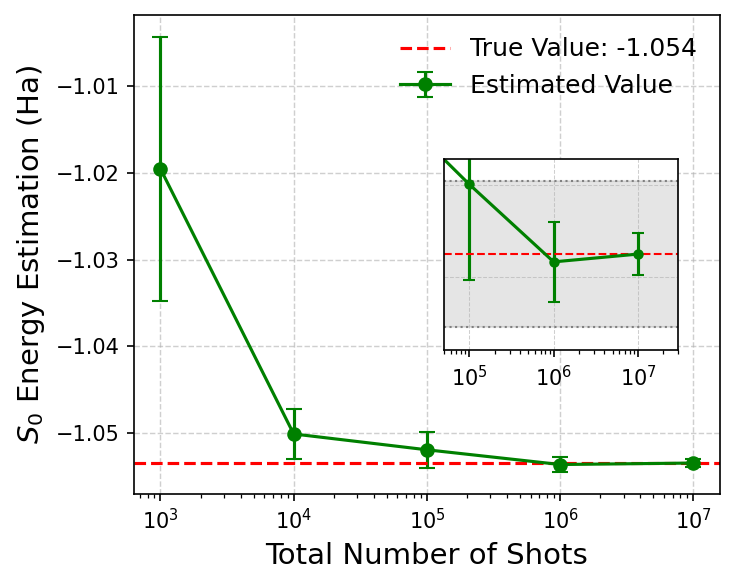

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Data
filtered_shots = [shot for shot in total_shots if shot != 10**2]  # Exclude 10^2
filtered_s0_means = [mean for shot, mean in zip(total_shots, s0_means) if shot != 10**2]
filtered_s0_stds = [std for shot, std in zip(total_shots, s0_stds) if shot != 10**2]

true_s0 = -1.053513
tolerance = 0.0016  # Chemical accuracy tolerance

# Create the main figure
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)

# Main plot: S0 Energy Estimation with error bars
ax.errorbar(filtered_shots, filtered_s0_means, yerr=filtered_s0_stds, 
            marker='o', linestyle='-', linewidth=1.5, markersize=6, color='green', capsize=4, label="Estimated Value")
ax.axhline(y=true_s0, color='red', linestyle='--', linewidth=1.5, label='True Value: -1.054')

# Set logarithmic scale and labels for main plot
ax.set_xscale('log')
ax.set_xlabel('Total Number of Shots', fontsize=14)
ax.set_ylabel('$S_0$ Energy Estimation (Ha)', fontsize=14)
ax.legend(fontsize=12, frameon=False, loc='upper right')  # Legend in upper right for main plot
ax.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.6)

# Add inset zoomed-in view
ax_inset = inset_axes(ax, width="40%", height="40%", loc='center right', borderpad=2)  # Center right position
ax_inset.errorbar(filtered_shots, filtered_s0_means, yerr=filtered_s0_stds, 
                  marker='o', linestyle='-', linewidth=1.5, markersize=4, color='green', capsize=3)
ax_inset.axhline(y=true_s0, color='red', linestyle='--', linewidth=1, label='True Value: -1.054')
ax_inset.fill_between([0.5*10**5, 3*10**7], true_s0 - tolerance, true_s0 + tolerance, 
                      color='grey', alpha=0.2, label='Chemical Accuracy')
ax_inset.axhline(y=true_s0 + tolerance, color='grey', linestyle='dotted', linewidth=1)
ax_inset.axhline(y=true_s0 - tolerance, color='grey', linestyle='dotted', linewidth=1)

# Customize the inset plot
ax_inset.set_xlim(0.5*10**5, 3*10**7)  # X-axis range for zoomed-in view
ax_inset.set_ylim(true_s0 - tolerance - 0.0005, true_s0 + tolerance + 0.0005)  # Narrower y-range
ax_inset.set_xscale('log')
ax_inset.grid(True, which="major", linestyle="--", linewidth=0.5, alpha=0.6)
ax_inset.tick_params(axis='y', which='both', left=False, labelleft=False)

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig("figures/s0_energy_convergence_zoom.pdf", format="pdf", dpi=300)
plt.show()

In [7]:
matrix_data = {"Mean S_off": mean_s_off, "STD S_off": std_s_off, "Mean H_off": mean_h_off, "STD H_off": std_h_off, "Mean H_diag": mean_h_diag, "STD H_diag": std_h_diag, "Mean S0": mean_s0, "STD S0": std_s0, "Mean T1": mean_t1, "STD T1": std_t1}
df = pd.DataFrame(matrix_data)
print(df)

   Mean S_off  STD S_off  Mean H_off  STD H_off  Mean H_diag  STD H_diag  \
0    0.518624   0.116274   -0.556787   0.118962    -0.763874    0.062949   
1    0.836938   0.055183   -0.893235   0.049565    -0.985553    0.022317   
2    0.892363   0.038309   -0.951493   0.037591    -1.036960    0.008229   
3    0.892352   0.013781   -0.952443   0.013250    -1.041131    0.002172   
4    0.893545   0.006909   -0.952860   0.006473    -1.040894    0.001227   
5    0.894171   0.005231   -0.953597   0.004722    -1.041222    0.000548   

    Mean S0    STD S0   Mean T1    STD T1  
0 -0.866781  0.059568 -0.417026  0.135449  
1 -1.022674  0.012483 -0.560322  0.113574  
2 -1.050732  0.003816 -0.796019  0.029179  
3 -1.053488  0.001109 -0.823886  0.003295  
4 -1.052922  0.001143 -0.826899  0.001907  
5 -1.053136  0.000464 -0.827991  0.000380  


In [14]:
# Creating the DataFrame
data = {
    'Mean Fidelity 1': mean_fidelity1,
    'STD Fidelity 1': std_fidelity1 ,
    'MSE Fidelity 1': mse_fidelity1,
    'MAE Fidelity 1': mae_fidelity1,
    'Mean Fidelity 2': mean_fidelity2,
    'STD Fidelity 2': std_fidelity2,
    'MSE Fidelity 2': mse_fidelity2,
    'MAE Fidelity 2': mae_fidelity2,
}
row_names = [str(x) for x in param_list]
df = pd.DataFrame(data, index = row_names)
print(df)

              Mean Fidelity 1  STD Fidelity 1  MSE Fidelity 1  MAE Fidelity 1  \
(10, 10)             1.156665        0.473795        0.249026        0.377074   
(31, 31)             0.912000        0.128395        0.024229        0.118556   
(100, 100)           0.998708        0.060482        0.003660        0.050263   
(316, 316)           0.986229        0.049389        0.002629        0.044716   
(1000, 1000)         0.993419        0.030335        0.000963        0.023319   

              Mean Fidelity 2  STD Fidelity 2  MSE Fidelity 2  MAE Fidelity 2  
(10, 10)             0.841087        0.262137        0.093969        0.263168  
(31, 31)             0.968882        0.198897        0.040528        0.173598  
(100, 100)           0.993606        0.078180        0.006153        0.061717  
(316, 316)           0.990614        0.058287        0.003485        0.046569  
(1000, 1000)         1.001368        0.033218        0.001105        0.030947  


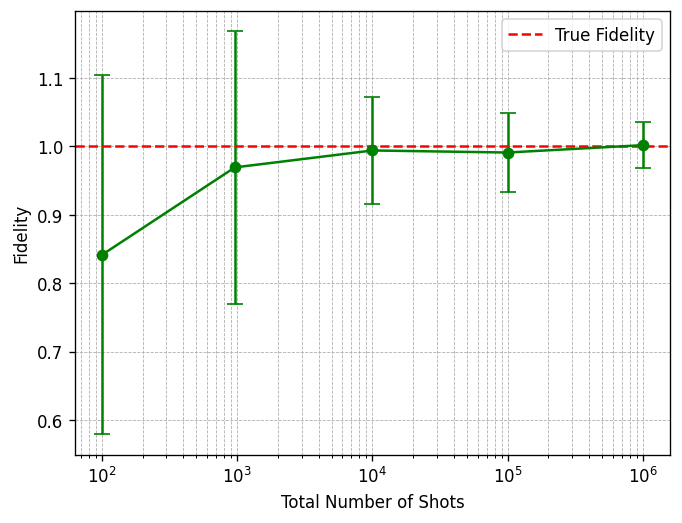

In [27]:
plt.figure(dpi=120)
#plt.errorbar(total_shots[1:], mean_fidelity1[1:], yerr=std_fidelity1[1:], marker='o', linestyle='-', color='green', capsize=5, label="S0")
#plt.errorbar(total_shots, mean_fidelity1, yerr=std_fidelity1, marker='o', linestyle='-', color='green', capsize=5, label="S0")
plt.errorbar(total_shots, mean_fidelity2, yerr=std_fidelity2, marker='o', linestyle='-', color='green', capsize=5)
# Add horizontal line for true S0
plt.axhline(y=1, color='r', linestyle='--', label='True Fidelity')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Add labels and title
plt.xlabel('Total Number of Shots')
plt.ylabel('Fidelity')
#plt.title('S0 vs Total Number of Shots')

# Add grid for better readability
plt.grid(True, which="both", ls="--", lw=0.5)

# Add legend
plt.legend()

# Show the plot
plt.show()

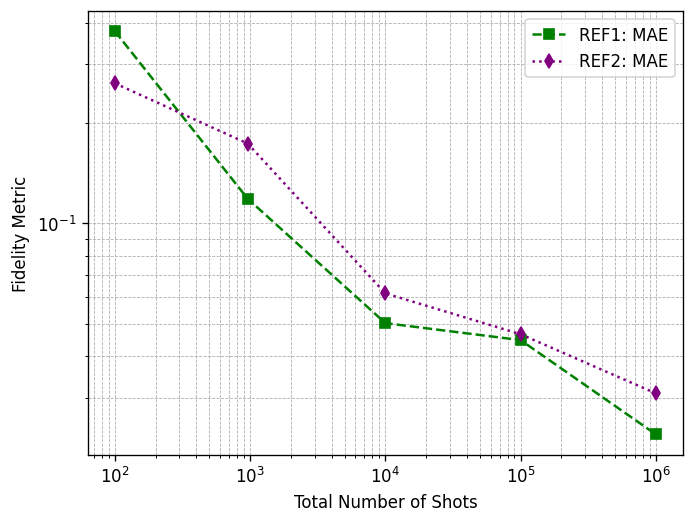

In [ ]:
total_shots = [x[0]*x[1] for x in param_list]

plt.figure(dpi=120)
# plt.plot(total_shots, mse_fidelity1, marker='o', linestyle='-', label='1st Ref State', color='green')
# plt.plot(total_shots, mse_fidelity2, marker='^', linestyle='--', label='2nd Ref State', color='red')
plt.plot(total_shots, mae_fidelity1, marker='s', linestyle='--', label='REF1: MAE', color='green')
plt.plot(total_shots, mae_fidelity2, marker='d', linestyle=':', label='REF2: MAE', color='purple')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Number of Shots')
plt.ylabel('Fidelity Metric')
#plt.title('Fidelity Metrics vs Total Number of Shots')
plt.grid(True, which="both", ls="--", lw = 0.5)
plt.legend()
# plt.savefig('figures/FidelityMSE_vs_Shots.pdf')
plt.show()

In [8]:
s0_mae_list = [np.mean([abs(x - s0_true) for x in s0]) for s0 in s0_list]
s0_mae_std_list = [np.std([abs(x - s0_true) for x in s0])/np.sqrt(10) for s0 in s0_list]
t1_mae_list = [np.mean([abs(x - t1_true) for x in t1]) for t1 in t1_list]

In [9]:
s0_mae_std_list

[0.03353217406664895,
 0.009205833573975754,
 0.0010058245485003198,
 0.00029012116568627596,
 0.00011258767004351767,
 6.257120460486188e-05]

In [65]:
s0_mae_list

[0.17844461579521836,
 0.03399790797280213,
 0.0035746129835466435,
 0.002157278395948392,
 0.0007297894039619779,
 0.0003867574940570995]

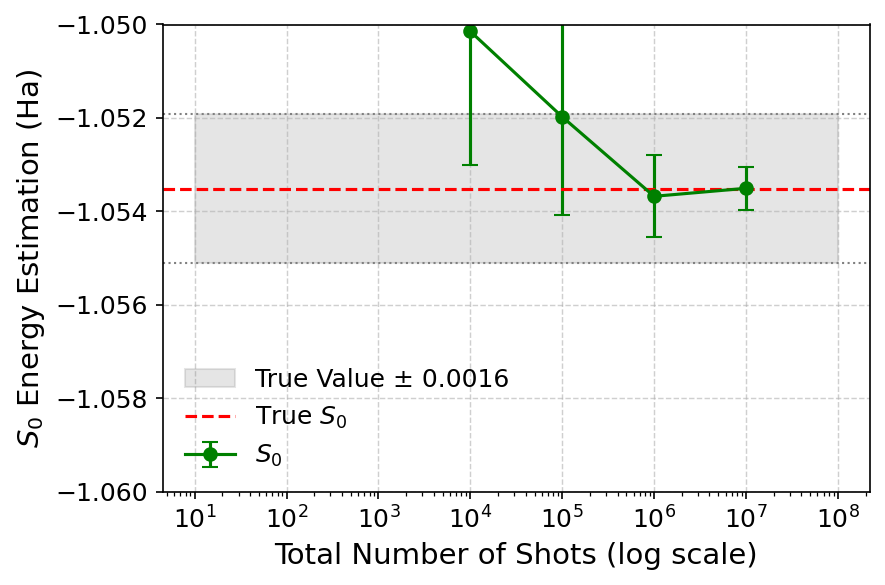

In [ ]:
import matplotlib.pyplot as plt

# Data
s0_means = [np.mean(x) for x in s0_list]  # Compute means of s0_list
s0_stds = [np.std(x) for x in s0_list]    # Compute standard deviations of s0_list

# Constants
true_s0 = -1.053513
tolerance = 0.0016  # True value ± tolerance

plt.figure(figsize=(6, 4), dpi=150)  # High resolution and compact size

# Plot S0 with error bars
plt.errorbar(total_shots, s0_means, yerr=s0_stds, 
             marker='o', linestyle='-', linewidth=1.5, markersize=6, color='green', capsize=4, label="$S_0$")

# Add shaded region for True Value ± tolerance
plt.fill_between([10, 10**8], true_s0 - tolerance, true_s0 + tolerance, 
                 color='grey', alpha=0.2, label='True Value ± 0.0016')

# Add horizontal lines for the True Value ± tolerance
plt.axhline(y=true_s0 + tolerance, color='grey', linestyle='dotted', linewidth=1)
plt.axhline(y=true_s0 - tolerance, color='grey', linestyle='dotted', linewidth=1)

# Add horizontal line for the True Value
plt.axhline(y=true_s0, color='red', linestyle='--', linewidth=1.5, label='True $S_0$')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Axis labels
plt.xlabel('Total Number of Shots (log scale)', fontsize=14)
plt.ylabel('$S_0$ Energy Estimation (Ha)', fontsize=14)

# Set y-axis limits
plt.ylim(-1.06, -1.05)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12, frameon=False, loc='lower left')

# Add grid
plt.grid(True, which="major", linestyle="--", linewidth=0.7, alpha=0.6)  # Less dense grid

# Adjust layout for compactness
plt.tight_layout()

# Save the plot as a vector graphic
#plt.savefig("figures/s0_energy_vs_shots_tolerance.pdf", format="pdf", dpi=300)

# Show the plot
plt.show()


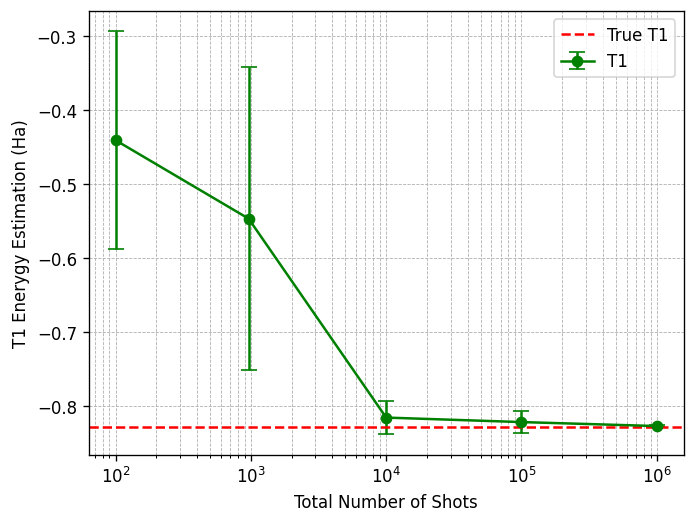

In [23]:
plt.figure(dpi=120)
plt.errorbar(total_shots, [np.mean(x) for x in t1_list], yerr=[np.std(x) for x in t1_list], marker='o', linestyle='-', color='green', capsize=5, label="T1")

# Add horizontal line for true S0
plt.axhline(y=t1_true, color='r', linestyle='--', label='True T1')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Add labels and title
plt.xlabel('Total Number of Shots')
plt.ylabel('T1 Enerygy Estimation (Ha)')
#plt.title('S0 vs Total Number of Shots')

# Add grid for better readability
plt.grid(True, which="both", ls="--", lw=0.5)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [52]:
t1_true

-0.8284433437356912

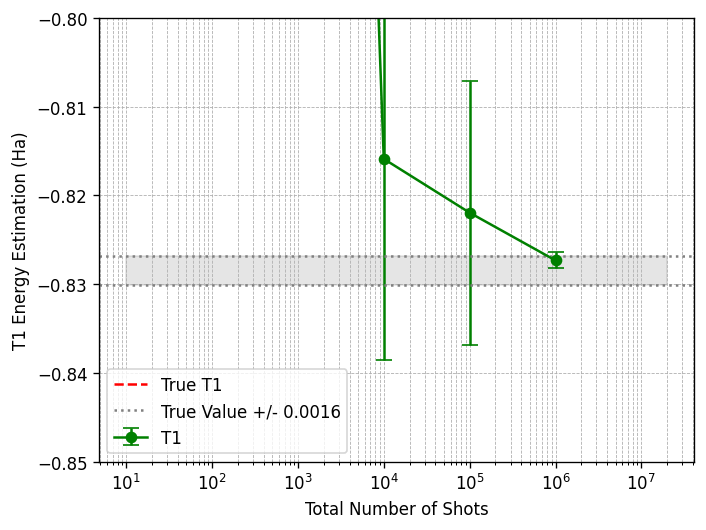

In [19]:
plt.figure(dpi=120)
plt.errorbar(total_shots, [np.mean(x) for x in t1_list], yerr=[np.std(x) for x in t1_list], marker='o', linestyle='-', color='green', capsize=5, label="T1")

# Add horizontal line for true S0
plt.axhline(y=s0_true, color='r', linestyle='--', label='True T1')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Add labels and title
plt.xlabel('Total Number of Shots')
plt.ylabel('T1 Energy Estimation (Ha)')
#plt.title('S0 vs Total Number of Shots')

plt.fill_between([10, 2*10**7], -0.82844-0.0016, -0.82844+0.0016, color='grey', alpha=0.2)
plt.axhline(y=-0.82844+0.0016, color='grey', linestyle='dotted', label='True Value +/- 0.0016')
plt.axhline(y=-0.82844-0.0016, color='grey', linestyle='dotted')
plt.ylim(-0.85, -0.8)


# Add grid for better readability
plt.grid(True, which="both", ls="--", lw=0.5)

# Add legend
plt.legend()

# Show the plot
plt.show()

c:\Users\17102\anaconda3\envs\shadow\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


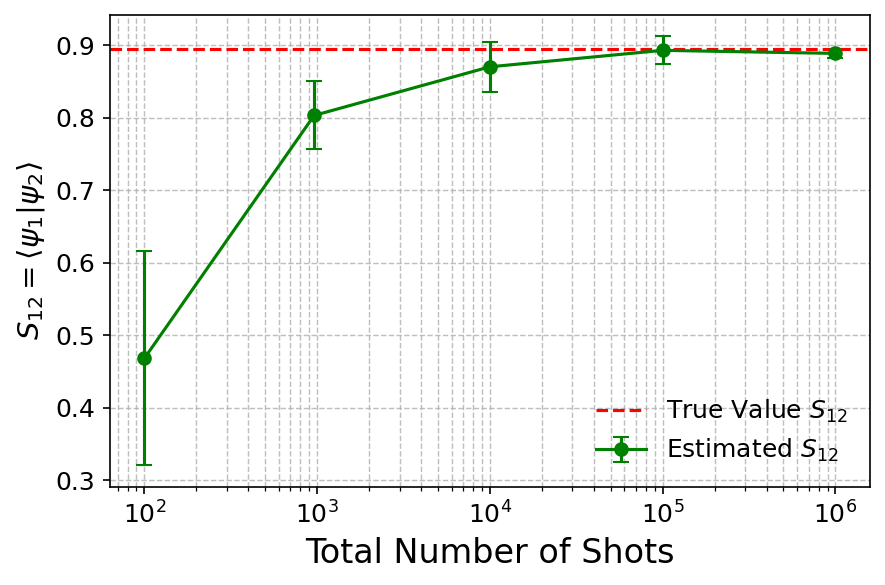

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)  # High resolution and compact size

# Plot error bars
plt.errorbar(total_shots, [np.mean(x) for x in s_off_list], 
             yerr=[np.std(x) for x in s_off_list], 
             marker='o', linestyle='-', color='green', capsize=4, markersize=6, linewidth=1.5, label="Estimated $S_{12}$")

# Add horizontal line for the true value of S_off
plt.axhline(y=s_off_true, color='red', linestyle='--', linewidth=1.5, label='True Value $S_{12}$')

# Set logarithmic scale for x-axis
plt.xscale('log')

# Axis labels
plt.xlabel('Total Number of Shots', fontsize=16)
plt.ylabel(r'$S_{12} = \langle \psi_1 | \psi_2 \rangle$', fontsize=14)

custom_y_ticks = np.arange(0.3,1, 0.1)  # Replace with your desired y-tick intervals
plt.yticks(custom_y_ticks, fontsize=12)

# Customize x-ticks (optional)
plt.xticks(fontsize=12)

# Add legend with updated style
plt.legend(fontsize=12, frameon=False, loc='lower right')

# Grid customization
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)

# Adjust layout for compactness
plt.tight_layout()

# Save the plot
plt.savefig("figures/s_off_vs_shots.pdf", format="pdf", dpi=150)

# Show the plot
plt.show()

c:\Users\17102\anaconda3\envs\shadow\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


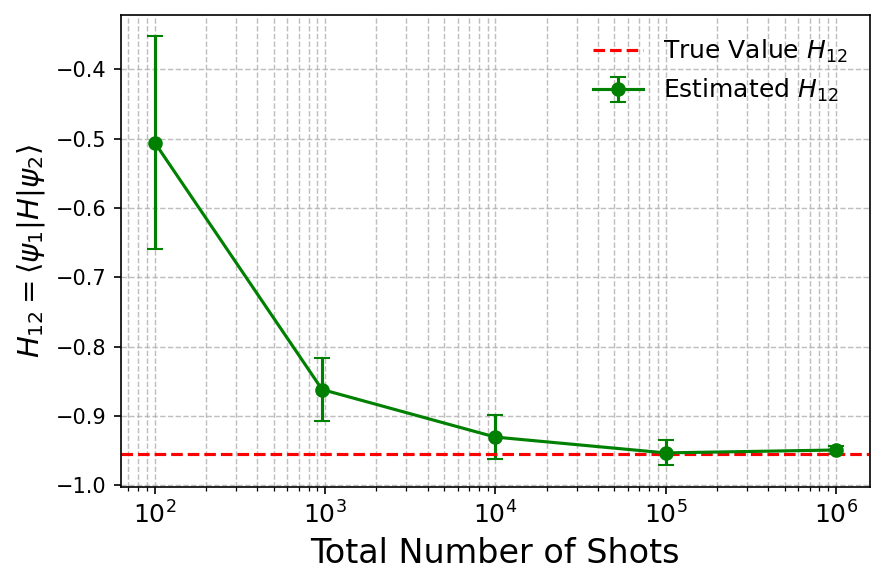

In [48]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)  # High resolution and compact size

# Plot error bars for the off-diagonal H elements
plt.errorbar(total_shots, [np.mean(x) for x in h_off_list], 
             yerr=[np.std(x) for x in h_off_list], 
             marker='o', linestyle='-', color='green', capsize=4, markersize=6, linewidth=1.5, label="Estimated $H_{12}$")

# Add horizontal line for the true value of H_off
plt.axhline(y=h_off_true, color='red', linestyle='--', linewidth=1.5, label='True Value $H_{12}$')

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Axis labels
plt.xlabel('Total Number of Shots', fontsize=16)
plt.ylabel(r'$H_{12} = \langle \psi_1 |H| \psi_2 \rangle$', fontsize=14)

# Custom y-ticks
#custom_y_ticks = np.arange(-0.95, -0.85, 0.02)  # Adjust range and interval for y-ticks
#plt.yticks(custom_y_ticks, fontsize=12)

# Customize x-ticks (optional)
plt.xticks(fontsize=12)

# Add legend with updated style
plt.legend(fontsize=12, frameon=False, loc='upper right')

# Grid customization
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)

# Adjust layout for compactness
plt.tight_layout()

# Save the plot as a vector graphic
plt.savefig("figures/h_off_vs_shots.pdf", format="pdf", dpi=150)

# Show the plot
plt.show()


c:\Users\17102\anaconda3\envs\shadow\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


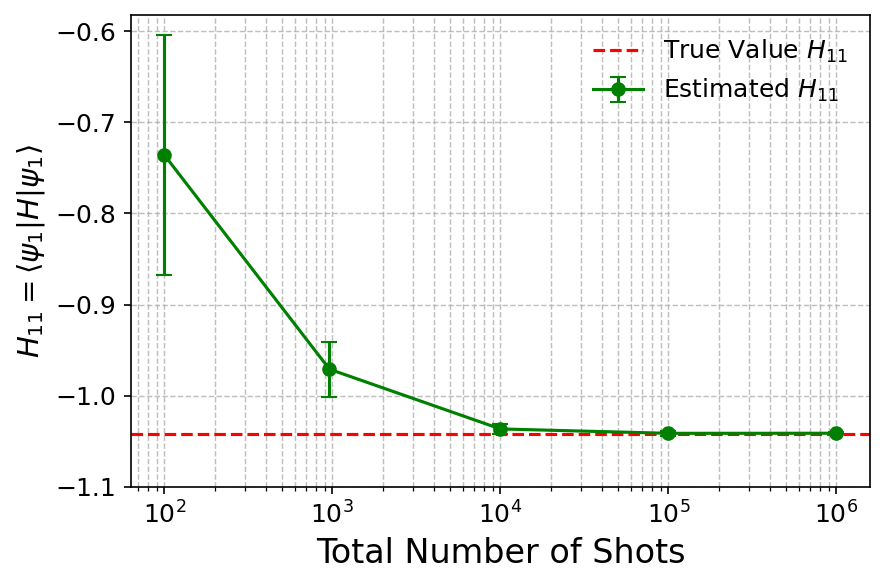

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)  # High resolution and compact size

# Plot error bars for the diagonal H elements
plt.errorbar(total_shots, [np.mean(x) for x in h_diag_list], 
             yerr=[np.std(x) for x in h_diag_list], 
             marker='o', linestyle='-', color='green', capsize=4, markersize=6, linewidth=1.5, label="Estimated $H_{11}$")

# Add horizontal line for the true value of H_diag
plt.axhline(y=h_diag_true, color='red', linestyle='--', linewidth=1.5, label='True Value $H_{11}$')

# Set logarithmic scale for the x-axis
plt.xscale('log')

# Axis labels
plt.xlabel('Total Number of Shots', fontsize=16)
plt.ylabel(r'$H_{11} = \langle \psi_1 |H| \psi_1 \rangle$', fontsize=14)

custom_y_ticks = np.arange(-1.1,-0.6, 0.1)  # Replace with your desired y-tick intervals
plt.yticks(custom_y_ticks, fontsize=12)
# Customize x-ticks (optional)
plt.xticks(fontsize=12)

# Add legend with updated style
plt.legend(fontsize=12, frameon=False, loc='upper right')

# Grid customization
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.8)

# Adjust layout for compactness
plt.tight_layout()

# Save the plot as a vector graphic
plt.savefig("figures/h_diag_vs_shots.pdf", format="pdf", dpi=150)

# Show the plot
plt.show()

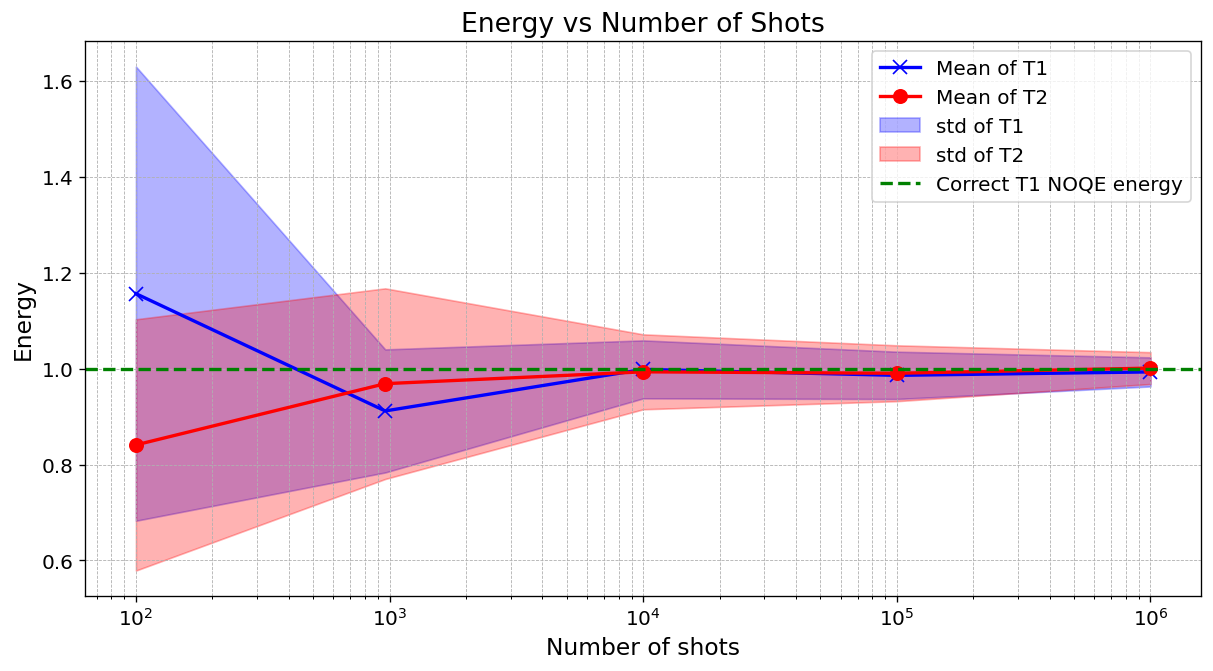

In [24]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

ax.plot(total_shots, np.array(mean_fidelity1), marker='x', linestyle='-', color='blue', linewidth=2, markersize=8, label='Mean of T1')
ax.plot(total_shots, np.array(mean_fidelity2), marker='o', linestyle='-', color='red', linewidth=2, markersize=8, label='Mean of T2')

# Plot the shaded areas for standard deviations
ax.fill_between(total_shots, np.array(mean_fidelity1) - np.array(std_fidelity1), np.array(mean_fidelity1) + np.array(std_fidelity1), color='blue', alpha=0.3, label='std of T1')
ax.fill_between(total_shots, np.array(mean_fidelity2) - np.array(std_fidelity2), np.array(mean_fidelity2) + np.array(std_fidelity2), color='red', alpha=0.3, label='std of T2')

# Plot the correct energy reference line
ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Correct T1 NOQE energy')

# Set the scale to log for x-axis
ax.set_xscale('log')

# Label the axes
ax.set_xlabel('Number of shots', fontsize=14)
ax.set_ylabel('Energy', fontsize=14)

# Set title
ax.set_title('Energy vs Number of Shots', fontsize=16)

# Add a legend
ax.legend(fontsize=12)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Show grid
ax.grid(True, which="both", ls="--", linewidth=0.5)

# Display the plot
plt.show()

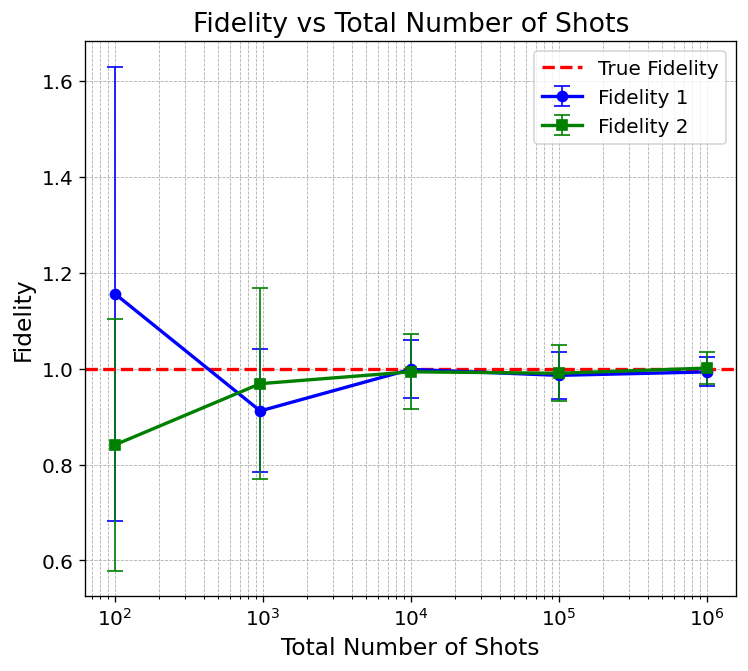

In [25]:
plt.figure(figsize=(7, 6), dpi=120)

# Plot fidelity1 with error bars
plt.errorbar(
    total_shots,
    [np.mean(x) for x in fidelity1_list],
    yerr=[np.std(x) for x in fidelity1_list],
    fmt='o',
    linestyle='-',
    color='blue',
    ecolor='blue',
    elinewidth=1,
    capsize=5,
    capthick=1,
    linewidth=2,
    markersize=6,
    label='Fidelity 1'
)

# Plot fidelity2 with error bars
plt.errorbar(
    total_shots,
    [np.mean(x) for x in fidelity2_list],
    yerr=[np.std(x) for x in fidelity2_list],
    fmt='s',
    linestyle='-',
    color='green',
    ecolor='green',
    elinewidth=1,
    capsize=5,
    capthick=1,
    linewidth=2,
    markersize=6,
    label='Fidelity 2'
)

# Plot the true fidelity line
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='True Fidelity')

# Set the scale to log for x-axis
plt.xscale('log')

# Label the axes
plt.xlabel('Total Number of Shots', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)

# Set title
plt.title('Fidelity vs Total Number of Shots', fontsize=16)

# Add a legend
plt.legend(fontsize=12)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)

# Show grid
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Display the plot
plt.show()